In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import similaritymeasures
from scipy.spatial import ConvexHull

%matplotlib inline

In [2]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_simulation = glob.glob(os.path.join(path + "\\Sim data\\", "*.csv"))

In [3]:
li = []
li_sim = []

window = 15
cols_to_filter = ['x', 'y', 'angle', 'k1', 'k2', 'x_model', 'y_model', 'angle_model', 'k1_model', 'k2_model']

for f, f_sim in zip(csv_files, csv_simulation):
    df = pd.read_csv(f, index_col=None, header=0)
    df_sim = pd.read_csv(f_sim, index_col=None, header=0)
    
    for col in cols_to_filter:
        y_average = []
        y = df[col]

        for ind in range(len(y) - window + 1):
            y_average.append(np.mean(y[ind:ind+window]))

        for ind in range(window - 1):
            y_average.insert(0, np.nan)

        df_new_col = pd.DataFrame({col + '_avrg':y_average})
        df = pd.concat([df, df_new_col], axis=1)
    
    repeat_n = [1] * len(df_sim)
    repeat_n[-1] = len(df) - len(df_sim) + 2 - window
    
    df_sim = df_sim.loc[df_sim.index.repeat(repeat_n)].reset_index(drop=True)
    
    li.append(df)    
    li_sim.append(df_sim)
    
# li[0]

In [4]:
df.time = pd.to_timedelta(df.time).astype('timedelta64[s]').astype(int)
# (df.time.iloc[-1] - df.time.iloc[0])
len(df.time)

253

In [5]:
cols_raw = ['x', 'y', 'angle', 'k1', 'k2']
cols = ['x_avrg', 'y_avrg', 'angle_avrg', 'k1_avrg', 'k2_avrg']
cols_model = ['x_model_avrg', 'y_model_avrg', 'angle_model_avrg', 'k1_model_avrg', 'k2_model_avrg']
cols_sim = ['x', 'y', 'phi', 'k1', 'k2']

In [6]:
df_dtw = pd.DataFrame(columns=cols_sim)

for df, df_sim in zip(li, li_sim):
    df_normalised = (df-df.mean())/df.std()
    df_sim_normalised = (df_sim-df_sim.mean())/df_sim.std()
    
    dtw_list = []
    
    for col, col_sim in zip(cols, cols_sim):

        sample1 = df_normalised[col].dropna().reset_index(drop=True).fillna(0)
        sample2 = df_sim_normalised[col_sim].reset_index(drop=True).fillna(0)

        exp_data = np.zeros((len(sample1), 2))
        exp_data[:, 0] = sample1.index.to_list()
        exp_data[:, 1] = sample1.to_list()

        num_data = np.zeros((len(sample2), 2))
        num_data[:, 0] = sample2.index.to_list()
        num_data[:, 1] = sample2.to_list()

        dtw, d = similaritymeasures.dtw(exp_data, num_data)
        dtw_list.append(dtw)
        
    df_dtw = df_dtw.append(pd.DataFrame([dtw_list], columns=cols_sim), ignore_index=True)

In [7]:
df_dtw

,x,y,phi,k1,k2
0,429.166339,299.797615,385.546026,70.606072,117.631930
1,216.660894,645.312853,434.557395,290.484640,549.796451
2,275.005512,167.720143,123.638113,66.678894,155.713481
3,16.625281,57.195667,26.168597,99.198261,22.733424
4,355.521156,98.367755,275.780922,191.731375,42.135492


<ipython-input-12-32334e9d89e8>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_lab)
<ipython-input-12-32334e9d89e8>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_lab)
<ipython-input-12-32334e9d89e8>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_lab)
<ipython-input-12-32334e9d89e8>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_lab)
<ipython-input-12-32334e9d89e8>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_lab)


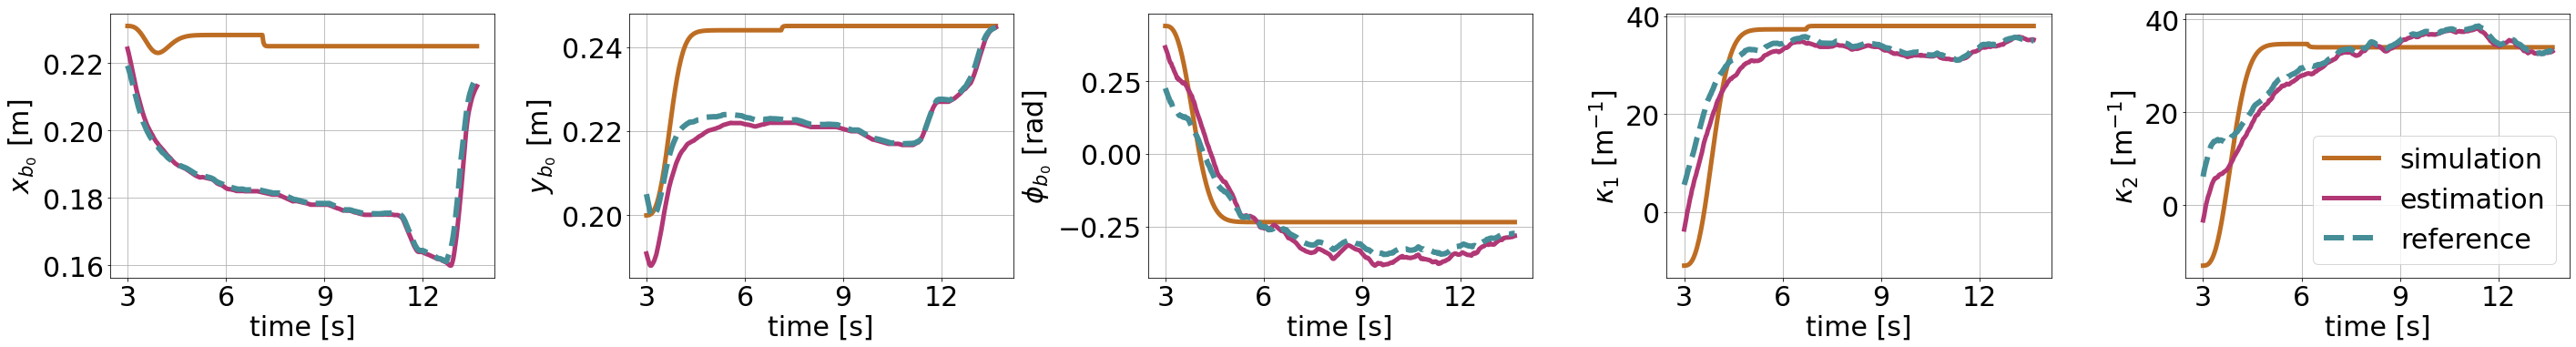

In [12]:
no = 2
df = li[no]
df_sim = li_sim[no]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(40, 6))
plt.rcParams['font.size'] = '30'
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Comparison of simulation and experimental results ", fontsize=18, y=0.95)

y_labels = [r'$x_{b_{0}}$ [m]', r'$y_{b_{0}}$ [m]', r'$\phi_{b_{0}}$ [rad]', r'$\kappa_{1}$ [m$^{-1}$]', r'$\kappa_{2}$ [m$^{-1}$]']
x_labels = ['exp 1', 'exp 2', 'exp 3', 'exp 4', 'exp 5']

for col_raw, col, col_model, col_sim, ax, y_label in zip(cols_raw, cols, cols_model, cols_sim, axs.ravel(), y_labels):
    df_ref = df[col_model].dropna().reset_index(drop=True)
    df_estim = df[col].dropna().reset_index(drop=True)
    
    n = len(df_sim)
    x_time = np.linspace(0, n / 15, n, endpoint=True)
    i = np.linspace(0, n-1, 9, endpoint=True).astype(int)
    x_lab = np.rint(x_time[i]).astype(int)
    
    df_sim[col_sim].plot(ax=ax, color='#BD6D23', linewidth=5)
    df_estim.plot(ax=ax, color='#B13775', linewidth=5)
    df_ref.plot(ax=ax, color='#458D97', linewidth=6, linestyle='dashed')
    
    points = np.column_stack((np.linspace(0, len(df[col_raw])-1, len(df[col_raw])).astype(int), df[col_raw].to_list()))
    hull = ConvexHull(points)
#     ax.fill(points[hull.vertices,0], points[hull.vertices,1], alpha=0.3)
    
    ax.set_ylabel(y_label, fontsize=30)
    ax.set_xlabel('time [s]', fontsize=30)
    ax.set_xticklabels(x_lab)
    ax.tick_params(labelsize=30)
#     ax.set_title("Case " + str(no+1), fontsize=16)
    ax.grid()
    
ax.legend(('simulation', 'estimation', 'reference'))

fig.tight_layout()
fig.subplots_adjust(wspace=0.35, hspace=0)
# fig.savefig('main_exp.png', format='png', dpi=600)

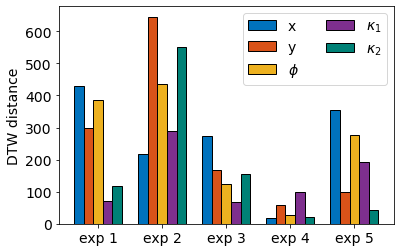

In [11]:
plt.rcParams['font.size'] = '14'
fig, ax = plt.subplots()
x = np.arange(len(cols_sim)) 
barWidth = 0.15 
bar_labels = ['x', 'y', r'$\phi$', r'$\kappa_1$', r'$\kappa_2$']
bar_colors = ['#0072bd', '#d95319', '#edb120', '#7e2f8e', '#008176']

for (columnName, columnData), bar_label, bar_color in zip(df_dtw.iteritems(), bar_labels, bar_colors):
    ax.bar(x, columnData.values, barWidth, label=bar_label, color = bar_color, edgecolor = "black")
    x = [i + barWidth for i in x]

# ax.set_title('Simulation vs Real Experiment')
ax.set_ylabel('DTW distance')
ax.set_xticks([x + 2*barWidth for x in np.arange(len(cols_sim))])
ax.set_xticklabels(x_labels)
# ax.tick_params(labelsize=30)
ax.legend(ncol=2)

In [77]:
targets = []

for df in li_sim:
#     df = (df-df.mean())/df.std()
    targets.append(df.tail(1).values.flatten().tolist()[:-2])

In [78]:
errors = []

for df, target in zip(li, targets):
#     df = (df-df.mean())/df.std()
    df = df[cols].dropna().reset_index(drop=True).fillna(0) - target
    errors.append(np.sqrt(np.square(df).sum(axis=1)).values)

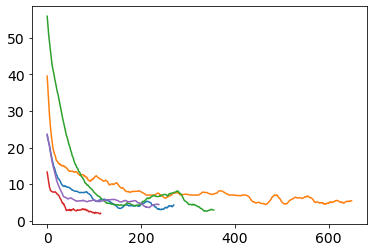

In [79]:
for error in errors:
    plt.plot(error)

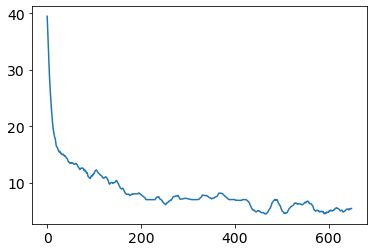

In [80]:
plt.rcParams['font.size'] = '14'
plt.plot(errors[1])